<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone Project: Automated Fraud Detection 
- Using the Enron Email Corpus to train Fraud Detection Models

## Problem Statement

The goal of this project is to build a classification model to predict if corruption in emails using text mining with the stakeholders being auditors, regulators and company's board of directors who have oversight over company management.

# Executive Summary

### The Enron Corporation

The Enron Corporation was an American energy company based in Houston, Texas formed in 1985 by Kenneth Lay after merging Houston Natural Gas and InterNorth.  The Enron scandal, initially made public in the fall of 2001, eventually led to the bankruptcy of the Enron Corporation.  The case led not only to the dissolution of Enron, but also the de facto dissolution of Arthur Andersen, one of the five largest accountancy firms in the world at the time.  Additionally, the case caused financial distress thoughtout the energy, trading and financial markets, ultimately leading to the implementation of the Sarbanes-Oxley Act in the US.   In 2001, it was the largest bankruptcy reorganization in American history, though that title was shortlived, with the collapse of Worldcom the following year. Nearly twenty years later the effects of the collapse are still felt in the financial and energy markets.  Given the enormous scope of the corporate failure in risk mangement, auditor oversight, and corporate culture, the red flags that were visible are worth ongoing investigation.


### The Enron Emails

The dataset we are reviewing is the remaining body of corporate emails mostly between 1997-2001.  The remaining body contains data from about 150 users, mostly senior management of Enron, and contains over 500k individual emails.  This data was originally made public, by the Federal Energy Regulatory Commission during its investigation. The source data used this project has been converted to .csv obtained from [**Kaggle**](https://www.kaggle.com/wcukierski/enron-email-dataset) and has not been included in the repository due to its size.

### Project workflow
The following is the general workflow for this project: 
+ **Exploratory Data Analysis (EDA)**
+ **Network Visualization**
+ **Pre-processing and Feature Engineering**
+ **Modeling and Evaluation**
+ **Conclusion and Recommendations**

For the purpose of this project, we will be using both the email metadata and the emails themselves to identify Enron employees requiring further investigation. The process will use a two step analysis where the output of an unsupervised algorithm is used as the input for a supervised learning algorithm to train a model to flag someone as being at risk of committing fraud using their email traffic. 

The model has an F1 score of 97% and would therefore be considered successful as an efficient model to review emails and identify people who may be at risk of committing fraud so that a more in-depth investigation can be performed. 

### Recommendations to further improve the model include:
    
- Getting access to computing resources to run the supervised learning algorithm on the full dataset
- Deeper review of language used in emails to determine if that could be a red flag for fraud

# 1. Data Extraction

In [118]:
import pickle
import email
import os
import numpy as np
import pandas as pd
from datetime import datetime
import networkx as nx
import wordcloud
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

from scipy import stats
from time import time

import networkx as nx

from nltk.tokenize.regexp import RegexpTokenizer
from sklearn.feature_extraction import _stop_words
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# Read the data into a DataFrame
emails_df = pd.read_csv('data/emails.csv')
print(emails_df.shape)
emails_df.head()

(517401, 2)


file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...

In [3]:
# A single message looks like this
print(emails_df['message'][0])

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


In [4]:
## Helper functions
def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

In [5]:
# Parse the emails into a list email objects
messages = list(map(email.message_from_string, emails_df['message']))
emails_df.drop('message', axis=1, inplace=True)
# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    emails_df[key] = [doc[key] for doc in messages]
# Parse content from emails
emails_df['content'] = list(map(get_text_from_email, messages))
# Split multiple email addresses
emails_df['From'] = emails_df['From'].map(split_email_addresses)
emails_df['To'] = emails_df['To'].map(split_email_addresses)

# Extract the root of 'file' as 'user'
emails_df['user'] = emails_df['file'].map(lambda x:x.split('/')[0])
del messages

emails_df.head()

file                                     Message-ID  \
0     allen-p/_sent_mail/1.  <18782981.1075855378110.JavaMail.evans@thyme>   
1    allen-p/_sent_mail/10.  <15464986.1075855378456.JavaMail.evans@thyme>   
2   allen-p/_sent_mail/100.  <24216240.1075855687451.JavaMail.evans@thyme>   
3  allen-p/_sent_mail/1000.  <13505866.1075863688222.JavaMail.evans@thyme>   
4  allen-p/_sent_mail/1001.  <30922949.1075863688243.JavaMail.evans@thyme>   

                                    Date                       From  \
0  Mon, 14 May 2001 16:39:00 -0700 (PDT)  (phillip.allen@enron.com)   
1   Fri, 4 May 2001 13:51:00 -0700 (PDT)  (phillip.allen@enron.com)   
2  Wed, 18 Oct 2000 03:00:00 -0700 (PDT)  (phillip.allen@enron.com)   
3  Mon, 23 Oct 2000 06:13:00 -0700 (PDT)  (phillip.allen@enron.com)   
4  Thu, 31 Aug 2000 05:07:00 -0700 (PDT)  (phillip.allen@enron.com)   

                          To    Subject Mime-Version  \
0     (tim.belden@enron.com)                     1.0   
1  (john.lavorato@enron.com)        Re:          1.0   
2   (leah.arsdall@enron.com)   Re: test          1.0   
3    (randall.gay@enron.com)                     1.0   
4     (greg.piper@enron.com)  Re: Hello          1.0   

                   Content-Type Content-Transfer-Encoding           X-From  \
0  text/plain; charset=us-ascii                      7bit  Phillip K Allen   
1  text/plain; charset=us-ascii                      7bit  Phillip K Allen   
2  text/plain; charset=us-ascii                      7bit  Phillip K Allen   
3  text/plain; charset=us-ascii                      7bit  Phillip K Allen   
4  text/plain; charset=us-ascii                      7bit  Phillip K Allen   

                                                X-To X-cc X-bcc  \
0           Tim Belden <Tim Belden/Enron@EnronXGate>              
1  John J Lavorato <John J Lavorato/ENRON@enronXg...              
2                                   Leah Van Arsdall              
3                                      Randall L Gay              
4                                         Greg Piper              

                                            X-Folder X-Origin  \
0  \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...  Allen-P   
1  \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...  Allen-P   
2    \Phillip_Allen_Dec2000\Notes Folders\'sent mail  Allen-P   
3    \Phillip_Allen_Dec2000\Notes Folders\'sent mail  Allen-P   
4    \Phillip_Allen_Dec2000\Notes Folders\'sent mail  Allen-P   

                    X-FileName  \
0  pallen (Non-Privileged).pst   
1  pallen (Non-Privileged).pst   
2                   pallen.nsf   
3                   pallen.nsf   
4                   pallen.nsf   

                                             content     user  
0                          Here is our forecast\n\n   allen-p  
1  Traveling to have a business meeting takes the...  allen-p  
2                     test successful.  way to go!!!  allen-p  
3  Randy,\n\n Can you send me a schedule of the s...  allen-p  
4                Let's shoot for Tuesday at 11:45.    allen-p

In [6]:
print('shape of the dataframe:', emails_df.shape)
# Find number of unique values in each columns
for col in emails_df.columns:
    print(col, emails_df[col].nunique())

shape of the dataframe: (517401, 18)
file 517401
Message-ID 517401
Date 224128
From 20328
To 54748
Subject 159290
Mime-Version 1
Content-Type 2
Content-Transfer-Encoding 3
X-From 27980
X-To 73552
X-cc 33701
X-bcc 132
X-Folder 5335
X-Origin 259
X-FileName 429
content 249025
user 150


In [7]:
# Set index and drop columns with two few values
emails_df = emails_df.set_index('Message-ID')\
    .drop(['file', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding'], axis=1)
# Parse datetime
emails_df['Date'] = pd.to_datetime(emails_df['Date'], utc=True)
emails_df.dtypes

Date          datetime64[ns, UTC]
From                       object
To                         object
Subject                    object
X-From                     object
X-To                       object
X-cc                       object
X-bcc                      object
X-Folder                   object
X-Origin                   object
X-FileName                 object
content                    object
user                       object
dtype: object

# 2. Exploratory Data Analysis

Text(0, 0.5, 'No. of emails')

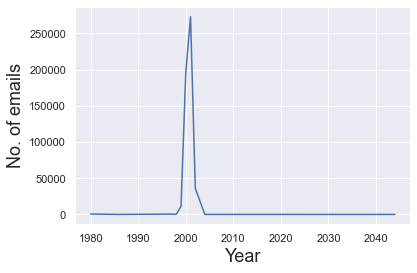

In [8]:
ax = emails_df.groupby(emails_df['Date'].dt.year)['From'].count().plot()
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('No. of emails', fontsize=18)

Text(0, 0.5, 'No. of emails')

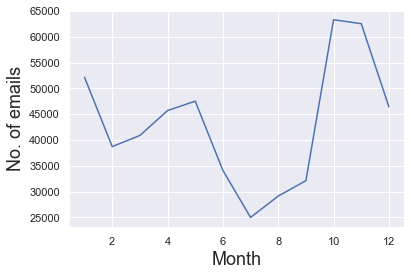

In [9]:
ax = emails_df.groupby(emails_df['Date'].dt.month)['From'].count().plot()
ax.set_xlabel('Month', fontsize=18)
ax.set_ylabel('No. of emails', fontsize=18)

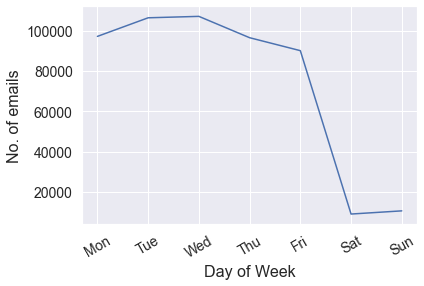

In [10]:
ax = emails_df.groupby(emails_df['Date'].dt.dayofweek)['From'].count().plot()
ax.set_xlabel('Day of Week', fontsize=16)
_ = ax.set_ylabel('No. of emails', fontsize=16) 
_ = plt.xticks(np.arange(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=30 , fontsize=14 )
_ = plt.yticks(fontsize=14)

Text(0, 0.5, 'No. of emails')

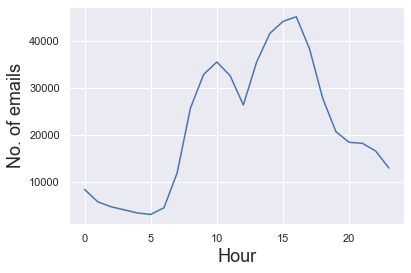

In [11]:
ax = emails_df.groupby(emails_df['Date'].dt.hour)['content'].count().plot()
ax.set_xlabel('Hour', fontsize=18)
ax.set_ylabel('No. of emails', fontsize=18)

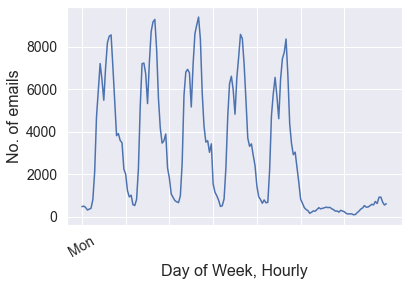

In [12]:
ax = emails_df.groupby([emails_df['Date'].dt.dayofweek, emails_df['Date'].dt.hour])['content'].count().plot()
ax.set_xlabel('Day of Week, Hourly', fontsize=16)
_ = ax.set_ylabel('No. of emails', fontsize=16) 
_ = plt.xticks(np.arange(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=30 , fontsize=14)
_ = plt.yticks(fontsize=14)
_ = ax.xaxis.set_ticks(np.arange(0, 168, 24))

Text(0, 0.5, 'Number of emails per month')

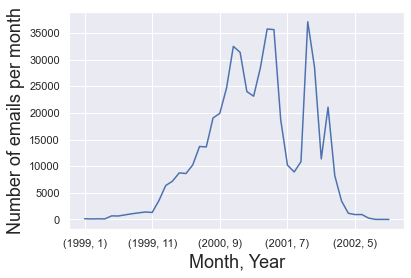

In [13]:
# number of emails grouped by year and month between 1999 to 2003
ax = emails_df[(emails_df['Date'].dt.year > 1998) & (emails_df['Date'].dt.year < 2003)].groupby([emails_df['Date'].dt.year,emails_df['Date'].dt.month])['From'].count().plot()
ax.set_xlabel('Month, Year', fontsize=18)
ax.set_ylabel('Number of emails per month', fontsize=18)

## Hypothesis Testing
The question I asked: 
Did employees send more emails when they arrived at work early in the morning or right before leaving work late in the afternoon in 2001? More specifically, is there any significant difference in the email volume between 8 to 10 am and 3 to 5 pm in 2001 excluding weekends?

Motivation: From looking at the hourly email volume in 2000 and 2001 (see below) we can notice a difference between email volume in the mornings and afternoons in 2001. One may interpret a higher volume of emails in the afternoons vs. mornings a sign of procrastination or lack of employees’ interest. 2001 is the year that Enron collapsed beacuse of financial fraud. Enron stock share price went from 80 dollars in Jan 2001 to 0 dollars in Dec 2001. 

Hypothesis Testing: 

Hypothesis: In 2001, employees sent more emails right before leaving work late in the afternoon (3-5 pm) than when they arrived at work early in the morning (8-10 am). 

Null: There is no significant difference between the number of emails sent between 8-10 am and 3-5 pm every day.

I will produce a new test statistics by deducting the number of emails sent between 8-10 am from the number of emails sent between 3-5 pm for each day. 

By conducting a one sample t-test we will see there is a significant difference between the number of email sent in the morning and afternoon in 2001. 

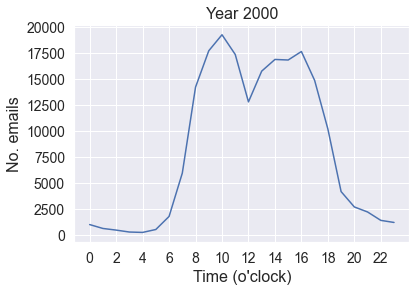

In [14]:
# number of emails grouped by the hour of the day in 2000
ax = emails_df[emails_df['Date'].dt.year ==2000].groupby(emails_df['Date'].dt.hour)['From'].count().plot()
ax.set_title('Year 2000', fontsize=16) 
ax.set_xlabel("Time (o'clock)", fontsize=16) 
ax.set_ylabel('No. emails', fontsize=16)
_ = plt.xticks(np.arange(12), fontsize=14 )
_ = plt.yticks(fontsize=14)
_ = ax.xaxis.set_ticks(np.arange(0, 24, 2))

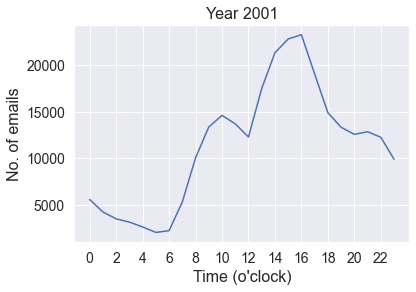

In [15]:
# number of emails grouped by the hour of the day in 2001
ax = emails_df[emails_df['Date'].dt.year ==2001].groupby(emails_df['Date'].dt.hour)['From'].count().plot()
ax.set_title('Year 2001', fontsize=16) 
ax.set_xlabel("Time (o'clock)", fontsize=16) 
ax.set_ylabel('No. of emails', fontsize=16)
_ = plt.xticks(np.arange(12), fontsize=14 )
_ = plt.yticks(fontsize=14)
_ = ax.xaxis.set_ticks(np.arange(0, 24, 2))

In [16]:
# selecting 2001 and removing weekends from data
df_weekdays = emails_df.loc[((emails_df['Date'].dt.year == 2001) & \
                      (emails_df['Date'].dt.dayofweek != 5) & (emails_df['Date'].dt.dayofweek != 6)), ['Date', 'From']]
# adding a column for Date without the hour information which will be used for groupby date
df_weekdays['Date_no_hr'] = df_weekdays['Date'].dt.date
df_weekdays.info()

<class 'pandas.core.frame.DataFrame'>
Index: 261102 entries, <18782981.1075855378110.JavaMail.evans@thyme> to <28618979.1075842030037.JavaMail.evans@thyme>
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype              
---  ------      --------------   -----              
 0   Date        261102 non-null  datetime64[ns, UTC]
 1   From        261102 non-null  object             
 2   Date_no_hr  261102 non-null  object             
dtypes: datetime64[ns, UTC](1), object(2)
memory usage: 8.0+ MB


In [17]:
# building a dataframe for emails between 8 to 10 am
df_am = df_weekdays[(df_weekdays['Date'].dt.hour >= 8) & (df_weekdays['Date'].dt.hour <= 10)]
df_am.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36966 entries, <30467968.1075855723641.JavaMail.evans@thyme> to <22366359.1075842015237.JavaMail.evans@thyme>
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   Date        36966 non-null  datetime64[ns, UTC]
 1   From        36966 non-null  object             
 2   Date_no_hr  36966 non-null  object             
dtypes: datetime64[ns, UTC](1), object(2)
memory usage: 1.1+ MB


In [18]:
# building a dataframe for emails between 3 to 5 pm
df_pm = df_weekdays[(df_weekdays['Date'].dt.hour >= 15) & (df_weekdays['Date'].dt.hour <= 17)]
df_pm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63390 entries, <27936946.1075855378542.JavaMail.evans@thyme> to <28979867.1075842029988.JavaMail.evans@thyme>
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   Date        63390 non-null  datetime64[ns, UTC]
 1   From        63390 non-null  object             
 2   Date_no_hr  63390 non-null  object             
dtypes: datetime64[ns, UTC](1), object(2)
memory usage: 1.9+ MB


In [19]:
# groupby Date and count the number of emails between 8-10 am
df_am_g = df_am.groupby(['Date_no_hr'])['From'].count().reset_index() # without reset index >> series
df_am_g.columns=['Date', 'Count_am']
df_am_g.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259 entries, 0 to 258
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      259 non-null    object
 1   Count_am  259 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.2+ KB


In [20]:
# statistical summary for the number of emails sent between 8-10 am
df_am_g['Count_am'].describe()

count    259.000000
mean     142.725869
std      148.486075
min        1.000000
25%       10.000000
50%       49.000000
75%      293.500000
max      488.000000
Name: Count_am, dtype: float64

In [21]:
# groupby Date and count the number of emails sent between 3-5 pm
df_pm_g = df_pm.groupby(['Date_no_hr'])['From'].count().reset_index() # without reset_index >> series
df_pm_g.columns=['Date', 'Count_pm']
df_pm_g.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      261 non-null    object
 1   Count_pm  261 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.2+ KB


In [22]:
# statistical summary for the number of emails sent between 3-5 pm
df_pm_g['Count_pm'].describe()

count    261.000000
mean     242.873563
std      145.987576
min        8.000000
25%      119.000000
50%      231.000000
75%      340.000000
max      734.000000
Name: Count_pm, dtype: float64

In [23]:
# Inner join of the two dataframes on the Date column
df_pm_am = pd.merge(df_am_g, df_pm_g, on='Date', how='inner')
df_pm_am.head()

Date  Count_am  Count_pm
0  2001-01-01         6        18
1  2001-01-02       304       252
2  2001-01-03       271       327
3  2001-01-04       265       275
4  2001-01-05       257       289

In [24]:
# Calculating the test-statistic and building a new column for it
df_pm_am['pm-am'] = df_pm_am['Count_pm']-df_pm_am['Count_am']
df_pm_am.head()

Date  Count_am  Count_pm  pm-am
0  2001-01-01         6        18     12
1  2001-01-02       304       252    -52
2  2001-01-03       271       327     56
3  2001-01-04       265       275     10
4  2001-01-05       257       289     32

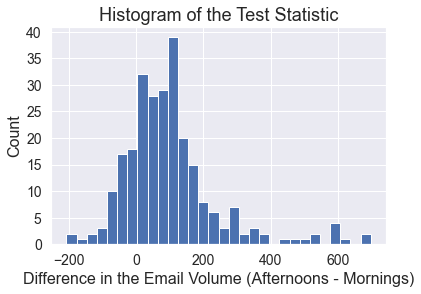

In [25]:
# histogram of the test-statistic, looks good for a t-test
_ = plt.hist(df_pm_am['pm-am'], bins=30)
_ = plt.xticks(fontsize=14)
_ = plt.yticks(fontsize=14)
_ = plt.xlabel('Difference in the Email Volume (Afternoons - Mornings)', fontsize=16)
_ = plt.ylabel('Count', fontsize=16)
_ = plt.title('Histogram of the Test Statistic', fontsize=18)

In [26]:
# statistical summary for the test-statistic
df_pm_am['pm-am'].describe()

count    259.000000
mean     101.366795
std      144.849804
min     -207.000000
25%       12.000000
50%       81.000000
75%      139.500000
max      697.000000
Name: pm-am, dtype: float64

In [27]:
# conducting a one sample t-test
stats.ttest_1samp(df_pm_am['pm-am'], 0)

Ttest_1sampResult(statistic=11.26231543822641, pvalue=3.397969981988647e-24)

In [28]:
# confidence interval for the test-statistic
stats.norm.interval(0.95, loc=np.mean(df_pm_am['pm-am']), scale=np.std(df_pm_am['pm-am'])/np.sqrt(len(df_pm_am['pm-am'])))
# scale= std or sem. sem: std/sqrt(N) confidence in the mean of N draws
# for a single draw (scale = std) the CI became (-181.98500329672487, 384.71859403031561)

(83.7601712836383, 118.97341944995244)

### Statistical Inference
In 2001, Enron employees on average sent 71% more emails between 3-5 pm than 8-10 am on a daily basis (p-value: 3e-24).

The average difference between the number of emails sent in the morning and in the afternoon is 110 emails on a daily basis. The 95% confidence interval is (83.8, 119.0).

It is good to mention that on average Enron employees sent 1008 emails every day excluding weekends.

In [29]:
# Explore
print('Number of unique users:', emails_df.user.nunique())
print('Number of unique From email addresses:', emails_df.From.nunique())

Number of unique users: 150
Number of unique From email addresses: 20328


In [30]:
# Who has the most emails (sent and received combined)
user_emails_s = emails_df.groupby('user')['user'].count().sort_values(ascending=False)
print(user_emails_s.head())

user
kaminski-v    28465
dasovich-j    28234
kean-s        25351
mann-k        23381
jones-t       19950
Name: user, dtype: int64


In [31]:
# Explore more
top_user = emails_df[emails_df['user'] == 'kaminski-v'].groupby('To')['To'].count().sort_values(ascending=False)
print(top_user.head(40))

To
(vkaminski@aol.com)                                       4870
(vince.kaminski@enron.com)                                2353
(shirley.crenshaw@enron.com)                              1424
(vkamins@enron.com)                                       1294
(vince.j.kaminski@enron.com)                              1065
(j.kaminski@enron.com)                                     761
(stinson.gibner@enron.com)                                 448
(steven.leppard@enron.com)                                 201
(mike.roberts@enron.com)                                   195
(molly.magee@enron.com)                                    172
(vasant.shanbhogue@enron.com)                              150
(stinson.gibner@enron.com, vince.kaminski@enron.com)       149
(anita.dupont@enron.com)                                   142
(christie.patrick@enron.com)                               129
(kevin.moore@enron.com)                                    121
(zimin.lu@enron.com)                                

In [32]:
# Which email address sent the most emails?
email_sender_series = emails_df.groupby(['From'])['From'].count().sort_values(ascending=False)
print(email_sender_series.head())

From
(kay.mann@enron.com)          16735
(vince.kaminski@enron.com)    14368
(jeff.dasovich@enron.com)     11411
(pete.davis@enron.com)         9149
(chris.germany@enron.com)      8801
Name: From, dtype: int64


### Interesting to know

- The top email user (kaminski-v) had at least 6 different email addresses from enron.com and at least two personal email addresses from aol.com and stanford.edu. Out of 28,465 emails that he sent or received, 4,870 emails were sent to his personal email at aol.com and 14,368 emails were sent by one of his enron emails: vince.kaminski@enron.com.

In [33]:
# groupby user and "From" email address
email_sender_series_2 = emails_df.groupby(['user', 'From'])['From'].count().sort_values(ascending=False)
print(email_sender_series_2.head())

user          From                       
mann-k        (kay.mann@enron.com)           16658
kaminski-v    (vince.kaminski@enron.com)     14335
dasovich-j    (jeff.dasovich@enron.com)       9423
germany-c     (chris.germany@enron.com)       8663
shackleton-s  (sara.shackleton@enron.com)     8144
Name: From, dtype: int64


### So far

- There are some difference in the number of emails in the above tables. All of the emails sent by the users are not available in their own folder. Some emails are only available in the folders of recipient users. This means that the senders deleted those emails.
- Considering that some users used multiple email addresses at work and used email for personal matters as well, I decided to work with the "From" and "To" columns of the data for network visualization.

# 3. Network Visualization

In [34]:
# In order to draw a network graph we need to pay attention to the To column.
# NaN in To column: float nan
emails_df[emails_df['To'].isnull()].head()

Date  \
Message-ID                                                                
<15201149.1075855691021.JavaMail.evans@thyme> 2000-05-01 10:56:00+00:00   
<21975671.1075855665520.JavaMail.evans@thyme> 2000-12-13 16:35:00+00:00   
<9828978.1075855671241.JavaMail.evans@thyme>  2000-05-01 10:56:00+00:00   
<8236042.1075855673105.JavaMail.evans@thyme>  2000-01-08 00:23:00+00:00   
<26959382.1075855693279.JavaMail.evans@thyme> 2001-05-14 16:04:00+00:00   

                                                                        From  \
Message-ID                                                                     
<15201149.1075855691021.JavaMail.evans@thyme>      (phillip.allen@enron.com)   
<21975671.1075855665520.JavaMail.evans@thyme>  (messenger@ecm.bloomberg.com)   
<9828978.1075855671241.JavaMail.evans@thyme>       (phillip.allen@enron.com)   
<8236042.1075855673105.JavaMail.evans@thyme>     (owner-strawbale@crest.org)   
<26959382.1075855693279.JavaMail.evans@thyme>  (messenger@ecm.bloomberg.com)   

                                                 To  \
Message-ID                                            
<15201149.1075855691021.JavaMail.evans@thyme>  None   
<21975671.1075855665520.JavaMail.evans@thyme>  None   
<9828978.1075855671241.JavaMail.evans@thyme>   None   
<8236042.1075855673105.JavaMail.evans@thyme>   None   
<26959382.1075855693279.JavaMail.evans@thyme>  None   

                                                                    Subject  \
Message-ID                                                                    
<15201149.1075855691021.JavaMail.evans@thyme>             Re: DSL- Installs   
<21975671.1075855665520.JavaMail.evans@thyme>  Bloomberg Power Lines Report   
<9828978.1075855671241.JavaMail.evans@thyme>              Re: DSL- Installs   
<8236042.1075855673105.JavaMail.evans@thyme>                                  
<26959382.1075855693279.JavaMail.evans@thyme>  Bloomberg Power Lines Report   

                                                                                      X-From  \
Message-ID                                                                                     
<15201149.1075855691021.JavaMail.evans@thyme>                                Phillip K Allen   
<21975671.1075855665520.JavaMail.evans@thyme>  "Bloomberg.com" <messenger@ecm.bloomberg.com>   
<9828978.1075855671241.JavaMail.evans@thyme>                                 Phillip K Allen   
<8236042.1075855673105.JavaMail.evans@thyme>                       owner-strawbale@crest.org   
<26959382.1075855693279.JavaMail.evans@thyme>  "Bloomberg.com" <messenger@ecm.bloomberg.com>   

                                                                     X-To  \
Message-ID                                                                  
<15201149.1075855691021.JavaMail.evans@thyme>  Circuit Provisioning@ENRON   
<21975671.1075855665520.JavaMail.evans@thyme>    (undisclosed-recipients)   
<9828978.1075855671241.JavaMail.evans@thyme>   Circuit Provisioning@ENRON   
<8236042.1075855673105.JavaMail.evans@thyme>    undisclosed-recipients:,    
<26959382.1075855693279.JavaMail.evans@thyme>    (undisclosed-recipients)   

                                              X-cc X-bcc  \
Message-ID                                                 
<15201149.1075855691021.JavaMail.evans@thyme>              
<21975671.1075855665520.JavaMail.evans@thyme>              
<9828978.1075855671241.JavaMail.evans@thyme>               
<8236042.1075855673105.JavaMail.evans@thyme>               
<26959382.1075855693279.JavaMail.evans@thyme>              

                                                                                        X-Folder  \
Message-ID                                                                                         
<15201149.1075855691021.JavaMail.evans@thyme>    \Phillip_Allen_Dec2000\Notes Folders\'sent mail   
<21975671.1075855665520.JavaMail.evans@thyme>  \Phillip_Allen_Dec2000\Notes Folders\All docum...   
<98289

In [35]:
# Example of a message with To value of NaN
Tonan = emails_df.loc['<18647535.1075855377111.JavaMail.evans@thyme>',:]
print(Tonan['To'], type(Tonan['To']))

None <class 'NoneType'>


In [36]:
# Removing rows with NaN in To column
emails_df = emails_df[emails_df['To'].notnull()]
emails_df.shape

(495554, 13)

In [37]:
# See if there were any NaN values in the 'From' column. There were none.
# When we convert float to string notnull would not work anymore. 
emails_df['From'] = emails_df['From'].apply(str) 
emails_df[emails_df['From'] == 'nan'].shape

(0, 13)

In [38]:
# Helper function to split multiple email addresses in the 'To' column
def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        # set:no repeat element, frozenset:immutable set
        addrs = frozenset(map(lambda x: x.strip(), addrs)) 
    else:
        addrs = None
    return addrs

In [39]:
# Split multiple email addresses in the To column. The class of the resulting elements will be frozenset.
emails_df['To'] = emails_df['To'].apply(str) 
emails_df['To'] = emails_df['To'].apply(split_email_addresses)

In [40]:
# Extract the first, 2nd, and 3rd recipients from the To column and add them to the dataframe
emails_df['Recipient_1'] = emails_df['To'].apply(lambda x: list(x)[0])
emails_df['Recipient_2'] = emails_df['To'].apply(lambda x: list(x)[1] if len(list(x))>1 else None)
emails_df['Recipient_3'] = emails_df['To'].apply(lambda x: list(x)[2] if len(list(x))>2 else None)
emails_df['Recipient_4'] = emails_df['To'].apply(lambda x: list(x)[3] if len(list(x))>3 else None)

In [41]:
print('Number of emails with more than 1 recipient:', emails_df['Recipient_2'].notnull().sum())
print('Number of emails with more than 2 recipients:', emails_df['Recipient_3'].notnull().sum())
print('Number of emails with more than 3 recipients:', emails_df['Recipient_4'].notnull().sum())

Number of emails with more than 1 recipient: 140954
Number of emails with more than 2 recipients: 103890
Number of emails with more than 3 recipients: 87856


- By focusing on the first recipient we lose a lot of information in terms of the network. However, with 495,554 emails I have more information than I can present. A comprehensive approach would consider all the recipients in the network study. For a  simpler approach, I could have focused on emails with only one recipient (1:1 emails).  

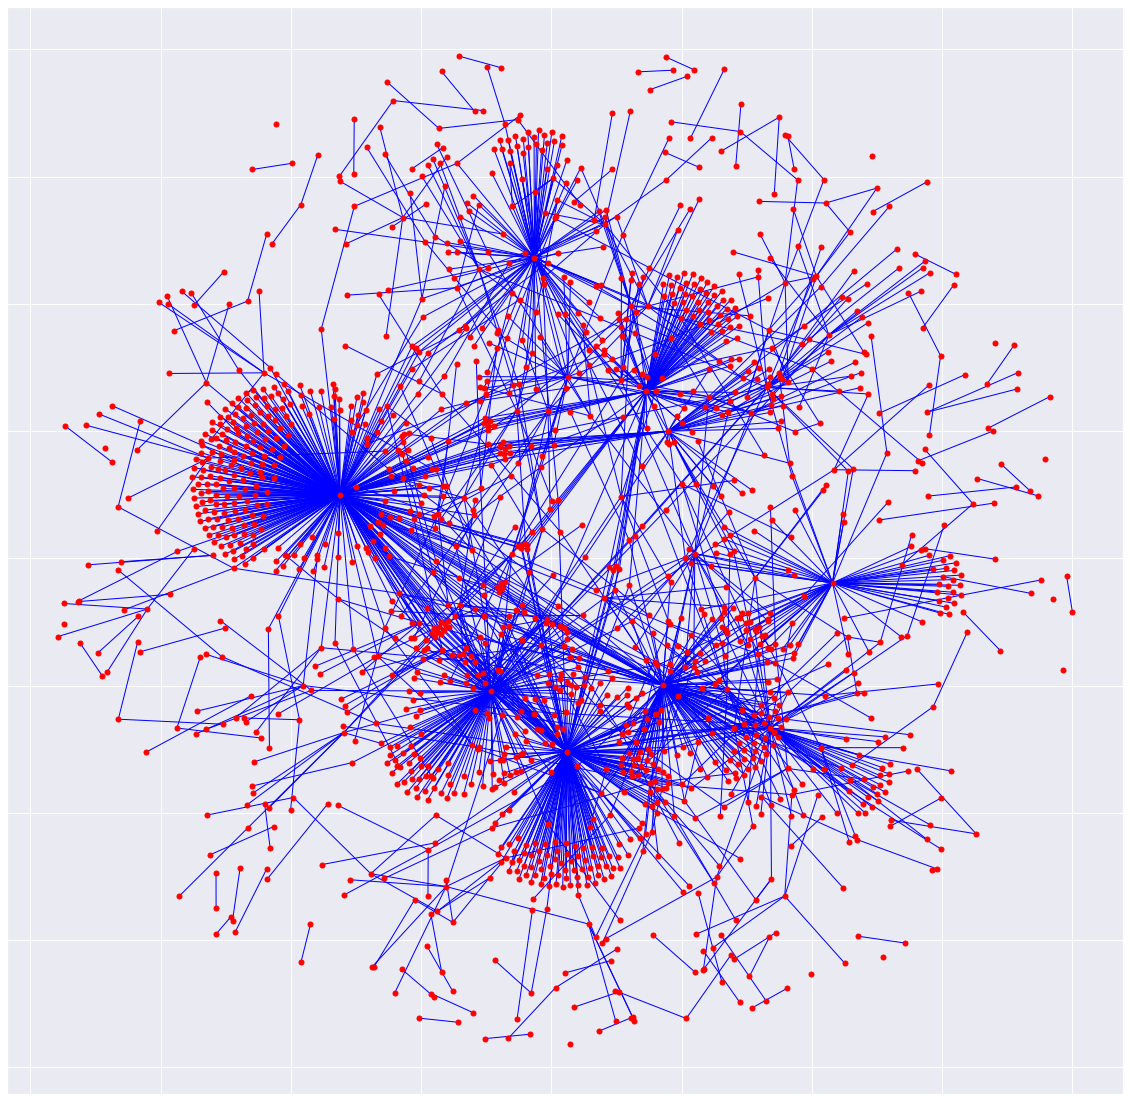

In [42]:
# Drawing a network graph for the first 10000 emails
df_reduced = emails_df[['From', 'Recipient_1']][:10000]

plt.figure(figsize=(20,20))
G = nx.from_pandas_edgelist(df_reduced, 'From', 'Recipient_1', edge_attr=None) 
pos = nx.spring_layout(G, k=.1)
nx.draw_networkx(G, pos, node_size=25, node_color='red', with_labels=False, edge_color='blue')
plt.show()

In [43]:
# In order to show some major clusters I will focus on the top email senders
top_ten_s = emails_df.groupby('From')['From'].count().sort_values(ascending=False) [:10]
print(top_ten_s)
top_ten = list(top_ten_s.index) # list of an index object
print(list(top_ten))

From
frozenset({'kay.mann@enron.com'})               16721
frozenset({'vince.kaminski@enron.com'})         14329
frozenset({'jeff.dasovich@enron.com'})          11387
frozenset({'pete.davis@enron.com'})              9149
frozenset({'sara.shackleton@enron.com'})         8757
frozenset({'chris.germany@enron.com'})           8745
frozenset({'enron.announcements@enron.com'})     8577
frozenset({'tana.jones@enron.com'})              8447
frozenset({'steven.kean@enron.com'})             6220
frozenset({'kate.symes@enron.com'})              5435
Name: From, dtype: int64
["frozenset({'kay.mann@enron.com'})", "frozenset({'vince.kaminski@enron.com'})", "frozenset({'jeff.dasovich@enron.com'})", "frozenset({'pete.davis@enron.com'})", "frozenset({'sara.shackleton@enron.com'})", "frozenset({'chris.germany@enron.com'})", "frozenset({'enron.announcements@enron.com'})", "frozenset({'tana.jones@enron.com'})", "frozenset({'steven.kean@enron.com'})", "frozenset({'kate.symes@enron.com'})"]


In [44]:
# Emails dataframe sent by only the top five senders
df_top_five_senders = emails_df[emails_df.From.isin(top_ten[0:5])]
print(df_top_five_senders.shape)

(60343, 17)


In [45]:
# Emails dataframe sent by only the 6th to 10th senders
df_2nd_five_senders = emails_df[emails_df.From.isin(top_ten[5:10])]
print(df_2nd_five_senders.shape)

(37424, 17)


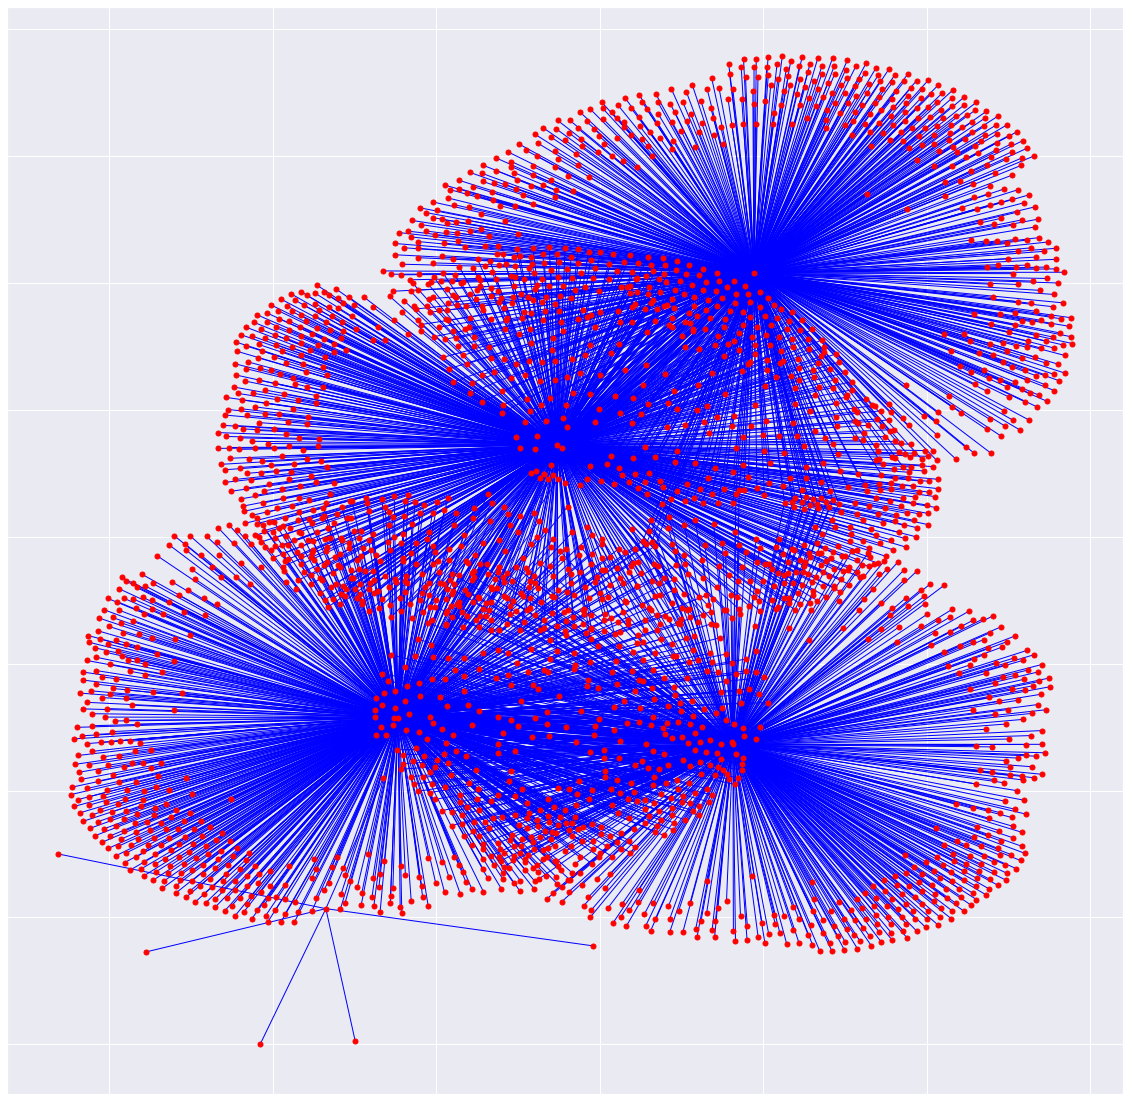

In [46]:
# Drawing a network graph for top 5 email senders
plt.figure(figsize=(20,20))
G = nx.from_pandas_edgelist(df_top_five_senders, 'From', 'Recipient_1', edge_attr=None)
pos = nx.spring_layout(G, k=.1)
nx.draw_networkx(G, pos, node_size=25, node_color='red', with_labels=False, edge_color='blue')
plt.show()

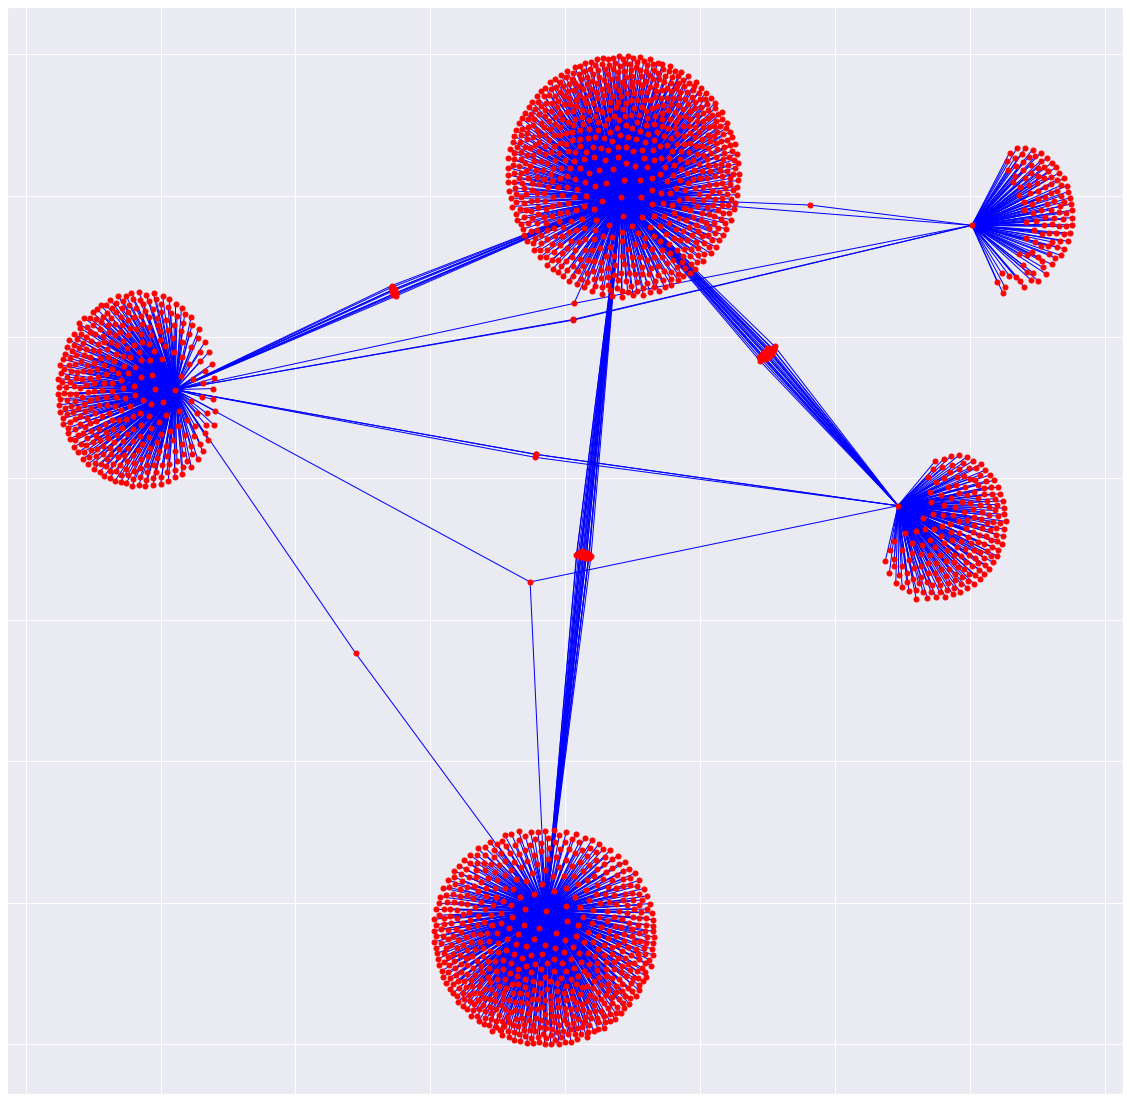

In [47]:
# Drawing a network graph for 6th to 10th top email senders
plt.figure(figsize=(20,20))
G = nx.from_pandas_edgelist(df_2nd_five_senders, 'From', 'Recipient_1', edge_attr=None)
pos = nx.spring_layout(G, k=.05)
nx.draw_networkx(G, pos, node_size=25, node_color='red', with_labels=False, edge_color='blue')
plt.show()

- The top network should have had five clusters but it only has four with one outlier
- It would be interesting to find out which email sender is the outlier

In [48]:
# detective work
df_top_five_senders.groupby('From')['Recipient_1'].nunique()

From
frozenset({'jeff.dasovich@enron.com'})      783
frozenset({'kay.mann@enron.com'})           652
frozenset({'pete.davis@enron.com'})           7
frozenset({'sara.shackleton@enron.com'})    838
frozenset({'vince.kaminski@enron.com'})     791
Name: Recipient_1, dtype: int64

In [49]:
# Emails dataframe sent by pete.davis@enron.com, the outlier node in the above group
df_pete = emails_df[emails_df['X-From'] =='Pete Davis']
df_pete

Date  \
Message-ID                                                                
<28633129.1075840616863.JavaMail.evans@thyme> 2001-01-16 10:56:00+00:00   
<27307713.1075840617460.JavaMail.evans@thyme> 2001-01-10 09:52:00+00:00   
<32070761.1075840723528.JavaMail.evans@thyme> 2001-01-16 10:56:00+00:00   
<33251278.1075840723985.JavaMail.evans@thyme> 2001-01-10 09:52:00+00:00   

                                                                              From  \
Message-ID                                                                           
<28633129.1075840616863.JavaMail.evans@thyme>  frozenset({'pete.davis@enron.com'})   
<27307713.1075840617460.JavaMail.evans@thyme>  frozenset({'pete.davis@enron.com'})   
<32070761.1075840723528.JavaMail.evans@thyme>  frozenset({'pete.davis@enron.com'})   
<33251278.1075840723985.JavaMail.evans@thyme>  frozenset({'pete.davis@enron.com'})   

                                                                                      To  \
Message-ID                                                                                 
<28633129.1075840616863.JavaMail.evans@thyme>  (frozenset({'portland.shift@enron.com'}))   
<27307713.1075840617460.JavaMail.evans@thyme>        (frozenset({'bill.iii@enron.com'}))   
<32070761.1075840723528.JavaMail.evans@thyme>  (frozenset({'portland.shift@enron.com'}))   
<33251278.1075840723985.JavaMail.evans@thyme>        (frozenset({'bill.iii@enron.com'}))   

                                                              Subject  \
Message-ID                                                              
<28633129.1075840616863.JavaMail.evans@thyme>  Re: Hour Ending 24 Bug   
<27307713.1075840617460.JavaMail.evans@thyme>  Re: Hour Ending 24 Bug   
<32070761.1075840723528.JavaMail.evans@thyme>  Re: Hour Ending 24 Bug   
<33251278.1075840723985.JavaMail.evans@thyme>  Re: Hour Ending 24 Bug   

                                                   X-From               X-To  \
Message-ID                                                                     
<28633129.1075840616863.JavaMail.evans@thyme>  Pete Davis     Portland Shift   
<27307713.1075840617460.JavaMail.evans@thyme>  Pete Davis  Bill Williams III   
<32070761.1075840723528.JavaMail.evans@thyme>  Pete Davis     Portland Shift   
<33251278.1075840723985.JavaMail.evans@thyme>  Pete Davis  Bill Williams III   

                                                                       X-cc  \
Message-ID                                                                    
<28633129.1075840616863.JavaMail.evans@thyme>                  David Poston   
<27307713.1075840617460.JavaMail.evans@thyme>  Portland Shift, David Poston   
<32070761.1075840723528.JavaMail.evans@thyme>                  David Poston   
<33251278.1075840723985.JavaMail.evans@thyme>  Portland Shift, David Poston   

                                              X-bcc  \
Message-ID                                            
<28633129.1075840616863.JavaMail.evans@thyme>         
<27307713.1075840617460.JavaMail.evans@thyme>         
<32070761.1075840723528.JavaMail.evans@thyme>         
<33251278.1075840723985.JavaMail.evans@thyme>         

                                                                                       X-Folder  \
Message-ID                                                                                        
<28633129.1075840616863.JavaMail.evans@thyme>  \mark guzman 6-28-02\Notes Folders\All documents   
<27307713.1075840617460.JavaMail.evans@thyme>  \mark guzman 6-28-02\Notes Folders\All documents   
<32070761.1075840723528.JavaMail.evans@thyme>    \mark guzman 6-28-02\Notes Folders\Notes inbox   
<33251278.1075840723985.JavaMail.evans@thyme>    \mark guzman 6-28-02\Notes Folders\Notes inbox   

                                               X-Origin  \
Message-ID                                                
<28633129.1075840616863.JavaMail.evans@thyme>  GUZMAN-M   
<27307713.1075840617460.JavaMail.evans@thyme>  G

In [50]:
# We can have a look at one of his emails to himself:
df_pete['content'][3]

'Bill,\n\nWhen you say "roll into the new day", to which process are you referring?  \nCreating Customer Finals, etc.?\n\nSome process is causing the "false finals" to be stored and it is that \nprocess I must isolate in order to re-create and fix the bug.\n\nYour help is greatly appreciated!\n\nPete\n\n\n   \n\t\n\t\n\tFrom:  Bill Williams III                           01/10/2001 09:01 AM\n\t\n\nTo: Pete Davis/HOU/ECT@ECT\ncc: Portland Shift \nSubject: Re: Hour Ending 24 Bug  \n\nPete,\n\nThis "bug" initiates as we roll into the new day, as for the exact time...we \nwill have to watch closely and get back to you on that.  The bug  or false \nfinals are an exact duplicate of the previous days finals for that schedule.  \nIf the current day has a null value for HE 24, no new final will overwrite \nthe bug or false final.  Consequently we are left with false finals that have \nabsolutely no relation to anything that occurred on the current day.  Going \nforward, we will do our best to do

- "pete.davis@enron.com" is the outlier node in the network graph. Out of the 9,149 emails that Pete sent, he was the first recipeint of 9,142 emails. Only 7 emails were sent to other people in which the actual recipient email address was in the Cc field. He also repeated the Cc email addresses in the Bcc field as well.
- The specific style of this single user could have made us believe he was among the top ten email senders while he sent most of those emails to only himself. It appears that he used those emails to keep a log of his work as a lab notebook. Even when he sent emails to other people he put his email address in the To field and their email addresses in the Cc field. 

# 4. Pre-processing and Feature Engineering

### Word Count in the Subject Field and Content Field (for 1:1 emails between Enron employees)

In [51]:
# Count words in Subjects and content
tokenizer = RegexpTokenizer(r'(?u)\b\w\w+\b') # words with at least 2 alphanumeric char
emails_df['Subject'] = emails_df['Subject'].fillna('')
emails_df['subject_wc'] = emails_df['Subject'].map(lambda x: len(tokenizer.tokenize(x)))
emails_df['content_wc'] = emails_df['content'].map(lambda x: len(tokenizer.tokenize(x)))

I decided to focus on one to one email communications between employees which can say more about the users' writing styles.
I will remove the followings from dataset:
- emails with missing To field
- emails with same From and To fields
- emails with more than one recipient
- emails which were not from enron.com accounts

In [53]:
df_reduced = emails_df[emails_df['To'].notnull()]
df_reduced = df_reduced [(df_reduced['To'] != df_reduced['From']) & df_reduced['To'].map(len) == 1]
df_reduced = df_reduced [df_reduced['From'].str.contains('enron.com')]
print('This filtering step reduced the size of dataset from', len(emails_df),'to', len(df_reduced))

This filtering step reduced the size of dataset from 495554 to 340588


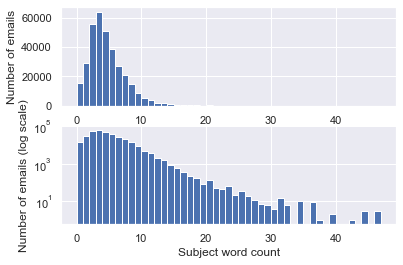

In [54]:
# Drawing histogram for subject word count
bins = df_reduced['subject_wc'].max()-df_reduced['subject_wc'].min() # xmin, xmax = plt.xlim()
_ = plt.subplot(2,1,1)
_ = plt.hist(df_reduced['subject_wc'], bins=bins)
_ = plt.xlabel ('Subject word count')
_ = plt.ylabel ('Number of emails')
# Drawing histogram for subject word count log scale y axes
_ = plt.subplot(2,1,2)
_ = plt.hist(df_reduced['subject_wc'], bins=bins)
_ = plt.xlabel ('Subject word count')
_ = plt.ylabel ('Number of emails (log scale)')
_ = plt.yscale('log')

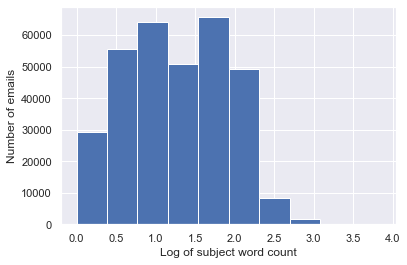

In [55]:
_ = plt.hist(np.log(df_reduced.loc[(df_reduced['subject_wc']> 0),'subject_wc']), bins= 10)
_ = plt.xlabel ('Log of subject word count')
_ = plt.ylabel ('Number of emails')

In [56]:
print('Subject word count statistics')
print(df_reduced['subject_wc'].describe())

Subject word count statistics
count    340588.000000
mean          4.160649
std           2.807253
min           0.000000
25%           2.000000
50%           4.000000
75%           6.000000
max          47.000000
Name: subject_wc, dtype: float64


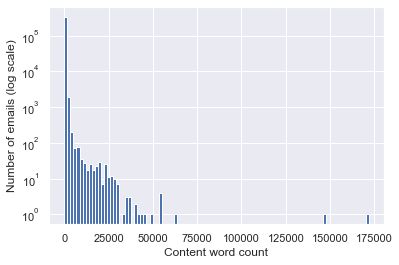

In [57]:
# Drawing histogram for content word count
_ = plt.hist(df_reduced['content_wc'], bins=100)
_ = plt.xlabel ('Content word count')
_ = plt.ylabel ('Number of emails (log scale)')
_ = plt.yscale('log')

Content word count statistics
count    340588.000000
mean        219.626819
std         776.327801
min           0.000000
25%          42.000000
50%         108.000000
75%         244.000000
max      171824.000000
Name: content_wc, dtype: float64


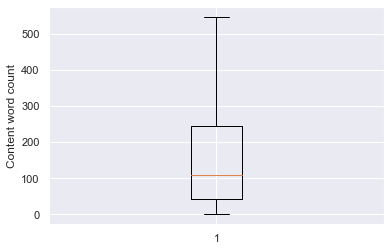

In [58]:
# Drawing box plot for content word count, fliers are not shown
print('Content word count statistics')
print(df_reduced['content_wc'].describe())
_ = plt.boxplot(df_reduced['content_wc'], showfliers=False)
_ = plt.ylabel ('Content word count')

In [59]:
groupby_sender = df_reduced.groupby('From').agg({
        'content': 'count', 
        'subject_wc': 'mean',
        'content_wc': 'mean'})
groupby_sender.rename(columns={'content': 'N emails', 
                                  'subject_wc': 'Subject word count', 
                                  'content_wc': 'Content word count'}, inplace=True)
print('Number of distinct from email addresses:', len(groupby_sender))
groupby_sender.sort_values('N emails', ascending=False).head()

Number of distinct from email addresses: 5887


N emails  Subject word count  \
From                                                                         
frozenset({'kay.mann@enron.com'})                14495            4.061469   
frozenset({'vince.kaminski@enron.com'})          13854            3.892739   
frozenset({'pete.davis@enron.com'})               9148            6.665829   
frozenset({'jeff.dasovich@enron.com'})            8898            4.915037   
frozenset({'enron.announcements@enron.com'})      8465            4.938452   

                                              Content word count  
From                                                              
frozenset({'kay.mann@enron.com'})                     197.007589  
frozenset({'vince.kaminski@enron.com'})               246.169193  
frozenset({'pete.davis@enron.com'})                    88.114889  
frozenset({'jeff.dasovich@enron.com'})                293.435604  
frozenset({'enron.announcements@enron.com'})          348.767395

In [60]:
# top 30 emailers
top30_emailers = groupby_sender.sort_values('N emails', ascending=False)[:30]

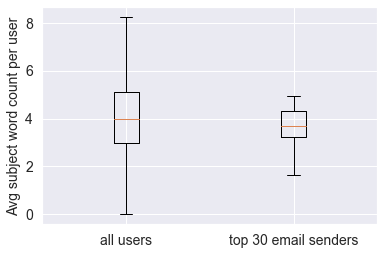

In [61]:
# Drawing boxplot for subject word count
_ = plt.boxplot([groupby_sender['Subject word count'], top30_emailers['Subject word count']], showfliers=False)
_ = plt.xticks([1, 2], ['all users', 'top 30 email senders'], fontsize=14)
_ = plt.yticks(fontsize=14)
_ = plt.ylabel ('Avg subject word count per user', fontsize=14)

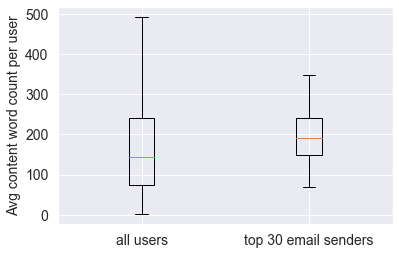

In [62]:
# Drawing boxplot for content word count, fliers are not shown
_ = plt.boxplot([groupby_sender['Content word count'], top30_emailers['Content word count']], showfliers=False)
_ = plt.xticks([1, 2], ['all users', 'top 30 email senders'], fontsize=14)
_ = plt.ylabel ('Avg content word count per user', fontsize=14)
_ = plt.yticks(fontsize=14)

In [63]:
print('All emailers content word count statistics')
print(groupby_sender['Content word count'].describe())

All emailers content word count statistics
count     5887.000000
mean       218.038678
std        607.460107
min          1.000000
25%         74.500000
50%        143.571429
75%        242.118625
max      30246.000000
Name: Content word count, dtype: float64


In [64]:
print('Top 30 emailers content word count statistics')
print(top30_emailers['Content word count'].describe())

Top 30 emailers content word count statistics
count     30.000000
mean     195.267085
std       80.246568
min       70.475322
25%      147.649769
50%      190.814014
75%      242.100810
max      413.177111
Name: Content word count, dtype: float64


C:\Users\zhelin\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\zhelin\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\zhelin\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\zhelin\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\zhelin\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\zhelin\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  

C:\Users\zhelin\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\zhelin\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\zhelin\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\zhelin\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\zhelin\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\zhelin\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  

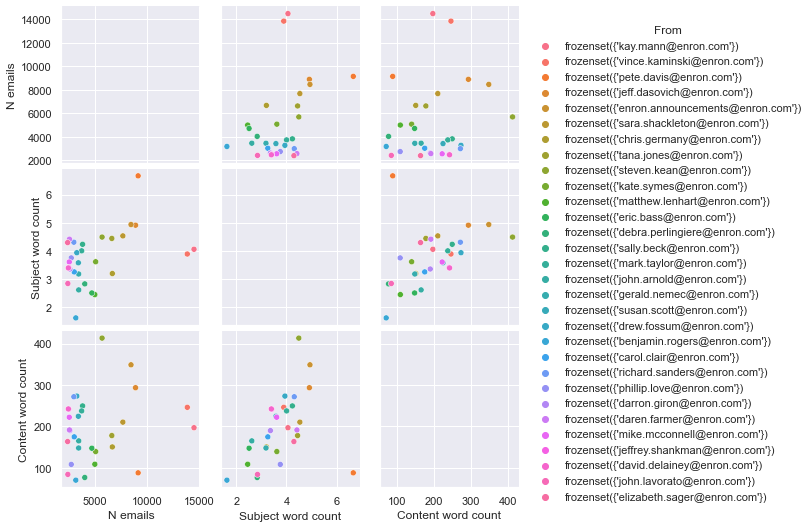

In [65]:
_ = sns.pairplot(top30_emailers.reset_index(), hue='From')
plt.rcParams["axes.labelsize"] = 20

For the top 30 emailers, there is a positive correlation between subject word count and content word count

In [66]:
print('Top 30 emailers:')
top30_emailers.corr()

Top 30 emailers:


N emails  Subject word count  Content word count
N emails            1.000000            0.411789            0.183012
Subject word count  0.411789            1.000000            0.422136
Content word count  0.183012            0.422136            1.000000

However when we consider all emailers there is no correlation between subject word count and content word count.

In [67]:
print('All emailers:')
groupby_sender.corr()

All emailers:


N emails  Subject word count  Content word count
N emails            1.000000           -0.006598            0.000346
Subject word count -0.006598            1.000000            0.066504
Content word count  0.000346            0.066504            1.000000

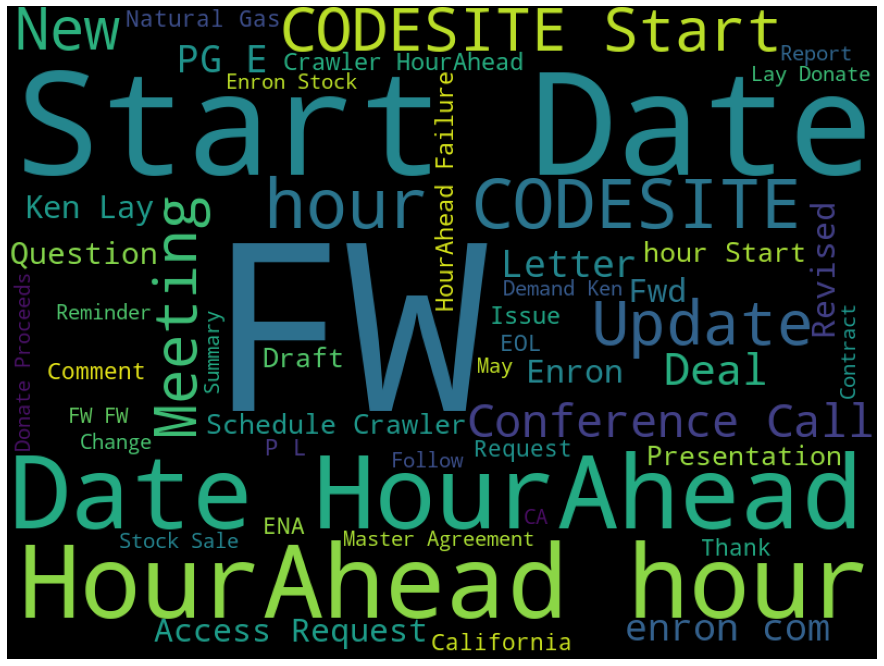

In [68]:
from nltk.corpus import stopwords

emails_df['Subject'] = emails_df['Subject'].fillna('') 

subjects = ' '.join(emails_df['Subject'])

fig, ax = plt.subplots(figsize=(16, 12))
wc = wordcloud.WordCloud(width=800, 
                         height=600, 
                         max_words=50,
                         stopwords = stopwords.words('english')).generate(subjects)
_ = ax.imshow(wc)
_ = ax.axis("off")

### Word cloud for the content (from 1000 sampled emails)

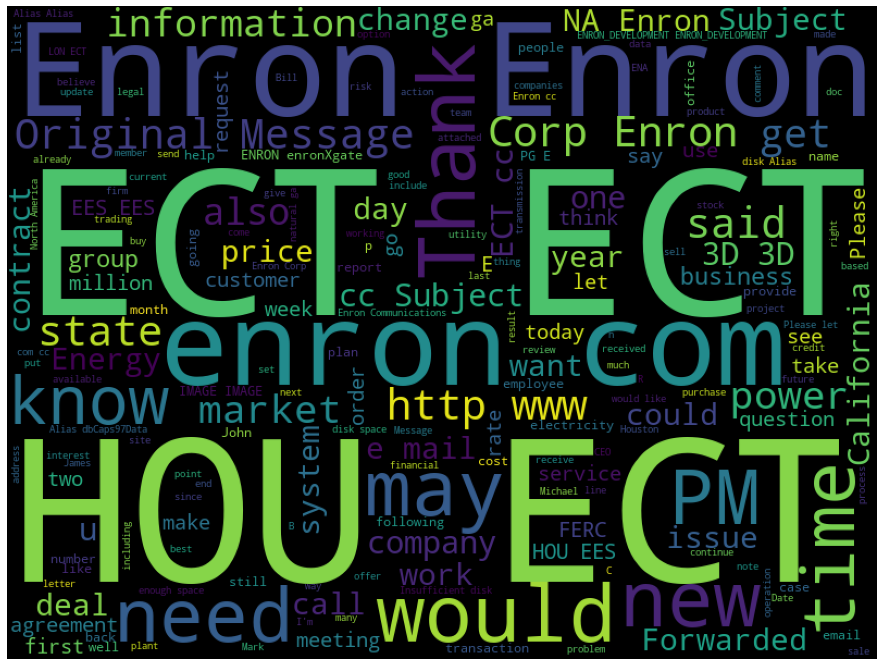

In [69]:
contents = ' '.join(emails_df.sample(1000)['content'])
fig, ax = plt.subplots(figsize=(16, 12))
wc = wordcloud.WordCloud(width=800, 
                         height=600, 
                         max_words=200,
                          stopwords = stopwords.words('english')).generate(contents)
_ = ax.imshow(wc)
_ = ax.axis("off")

## Word Frequency in the Subject Field
What were the most frequent words in the subject line of the emails? What are their exact order and count?

In [70]:
# What are the most common subject lines?
emails_df.groupby('Subject')['Subject'].count().sort_values(ascending=False)[:10]

Subject
                                                         18822
RE:                                                       6458
Re:                                                       6283
Demand Ken Lay Donate Proceeds from Enron Stock Sales     1124
FW:                                                        933
Schedule Crawler: HourAhead Failure                        900
Schedule Crawler: HourAhead Failure <CODESITE>             800
EnTouch Newsletter                                         375
Energy Issues                                              369
Williams Energy News Live -- today's video newscast        338
Name: Subject, dtype: int64

In [71]:
# drop the emails with no subject line
emails_df = emails_df[emails_df['Subject'] != 'nan']
# df.dropna(subset=['Subject'], axis=0, inplace=True) would work if we have not converted the column to str.

In [72]:
# Counting the most frequent words in the subject field before tokenization.
# It is necessary to convert the characters to lowercase.
pd.Series(' '.join(emails_df['Subject']).lower().split()).value_counts()[:10]

re:      154153
-         43196
for       38902
fw:       38674
of        25811
and       23685
to        22998
the       18608
enron     15923
on        15237
dtype: int64

In [73]:
# Alternatively we can use Counter from the collection module to count the most frequent words
Counter(" ".join(emails_df['Subject']).lower().split()).most_common(10)

[('re:', 154153),
 ('-', 43196),
 ('for', 38902),
 ('fw:', 38674),
 ('of', 25811),
 ('and', 23685),
 ('to', 22998),
 ('the', 18608),
 ('enron', 15923),
 ('on', 15237)]

In [74]:
# Tekenization will change the above results.
# The following list will not contain nan values.
subjects = ' '.join(emails_df['Subject'])
tokenizer = RegexpTokenizer(r'(?u)\b\w\w+\b')
subjects_tokens = tokenizer.tokenize(subjects) # class: list
print('Number of total tokens in the subject line of over 500000 emails:', len(subjects_tokens))

Number of total tokens in the subject line of over 500000 emails: 2186252


In [75]:
# lowercase the tokens 
subjects_tokens = list(map(str.lower,subjects_tokens))

In [76]:
Counter(subjects_tokens).most_common(10) # class collections.Counter

[('re', 157277),
 ('for', 39092),
 ('fw', 38784),
 ('of', 25949),
 ('and', 23808),
 ('to', 23203),
 ('enron', 21197),
 ('the', 18995),
 ('01', 18601),
 ('on', 15680)]

We need to remove the stop words from the tokenized list. It will be much faster to groupby tokens first and then eliminate the stop words. Otherwise every token in the list of 2,309,634 tokens has to be checked against stop words. In order to do so a dataframe will be built from the Counter.

In [77]:
# Make a dataframe from the Counter
word_df = pd.DataFrame.from_dict(Counter(subjects_tokens), orient='index').reset_index()
word_df.columns = ['word','count']
word_df.sort_values('count', ascending =False).reset_index(drop=True).head(10)

word   count
0     re  157277
1    for   39092
2     fw   38784
3     of   25949
4    and   23808
5     to   23203
6  enron   21197
7    the   18995
8     01   18601
9     on   15680

In [78]:
# Removing stop words
word_df = word_df[~word_df['word'].isin(stopwords.words('english'))].reset_index(drop=True).sort_values('count', ascending=False)
print(word_df.head(20))

           word  count
10           fw  38784
117       enron  21197
141          01  18601
28      meeting  15132
22         2001  11939
95          new  11405
15          gas  11004
372   agreement  10960
642      energy   9898
206       power   9626
85       report   9253
9844  hourahead   9069
153      update   8730
155          00   8426
666        date   8372
582        2000   8344
357        hour   8145
91      request   8118
1218      start   7703
132         com   6992


Among the most frequent words used in the subject line are '00', '2001, '01', 'agreement', 'meeting',... that were not shown on the word cloud at all or were shown with a relatively small font. In addition to showing repeat words, the word cloud did not do a good job in showing the most frequent words with bigger sizes.

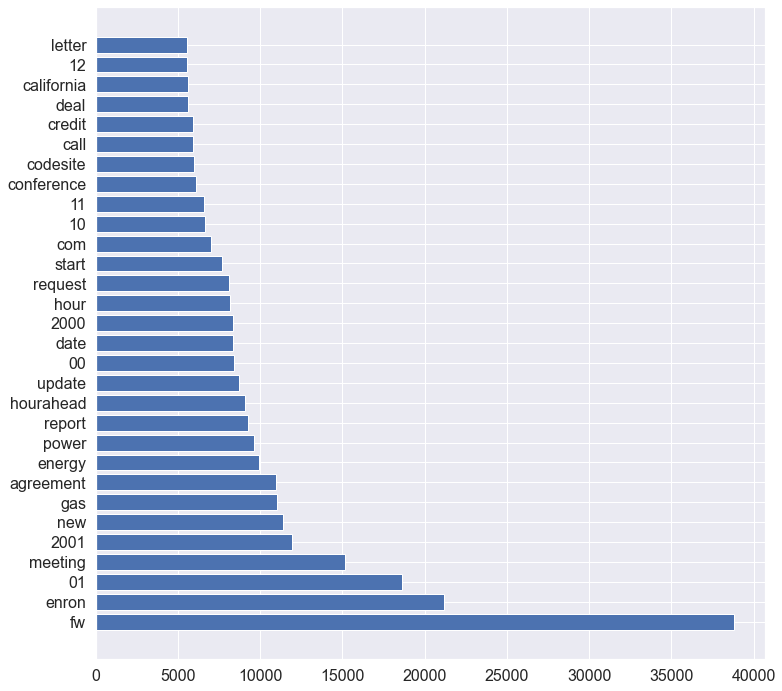

In [79]:
# bar plot, sorted alphabetically
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12, 12)
ax.barh(word_df.iloc[:30,0], word_df.iloc[:30,1])
ax.tick_params(axis='both', which='major', labelsize=16)

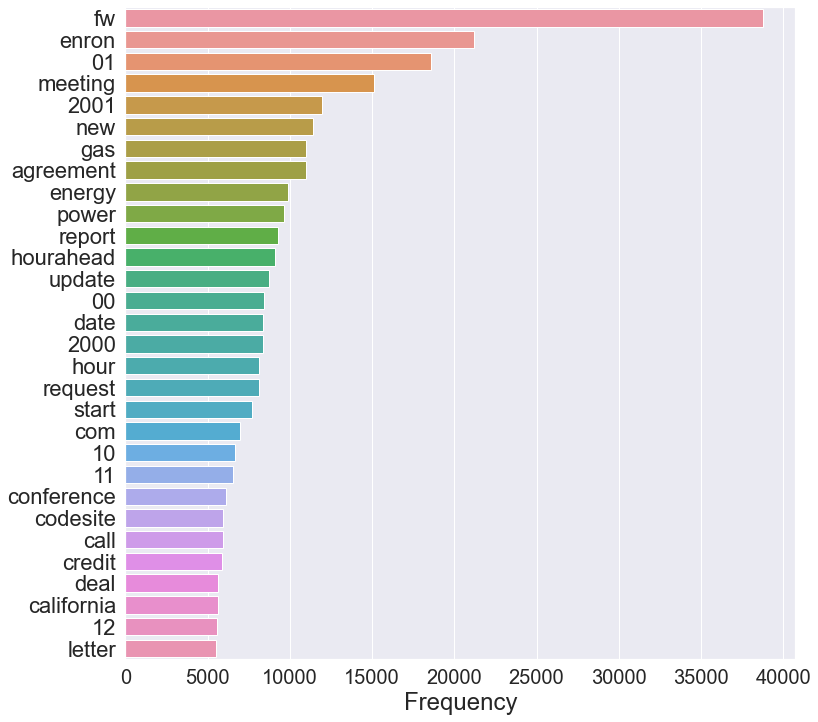

In [80]:
# bar plot with seaborn
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12, 12)
_ = sns.barplot(x=word_df.iloc[:30,1], y=word_df.iloc[:30,0], ax=ax)
_ = ax.tick_params(axis='x', which='major', labelsize=20)
_ = ax.tick_params(axis='y', which='major', labelsize=22)
_ = ax.set_xlabel('Frequency', fontsize=24)
_ = ax.set_ylabel('')

# 5. Modeling and Evaluation

In [84]:
#creating the vector object
vectorizer = TfidfVectorizer(stop_words = 'english', max_df=0.5, min_df = 2)

#fitting the vectorizer to the corpus
X = vectorizer.fit_transform(emails_df.content)

In [85]:
#the vectorizer outputs a sparse matrix of words, let's see how big it is
X.shape

(495554, 384952)

That is a very large matrix, too large to convert to a dense matrix. So we'll take a slice of the first 10,000 rows and columsn to review. Then we will make use of principal component analysis so we can plot the vectors.

<function matplotlib.pyplot.show(close=None, block=None)>

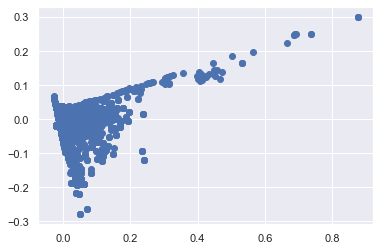

In [86]:
#slicing the first 10,000 rows and columns
X_slice = X[:10000,:10000]

#making our matrix 2D
X_dense = X_slice.todense()

#crating coordinates for a plot using PCA
coords = PCA(n_components =2).fit_transform(X_dense)
x= coords[:,0]
y=coords[:,1]

#creating the plot 
plt.scatter(x,y, c='b')
plt.show

In [87]:
#number of top words to grab
n = 25
#retrieving words from TF-IDF vector
feats = vectorizer.get_feature_names()
#Remove single-dimensional entries from X to get the rows to use
row = np.squeeze(X[1].toarray())
#sorting the rows
top_ids = np.argsort(row)[::-1][:n]
#creating a tuple of top features and their scores
top_feats = [(feats[i],row[i])for i in top_ids]
#saving the features to a df
top_df = pd.DataFrame(top_feats, columns=['features','score'])

In [88]:
top_df

features     score
0     meetings  0.396321
1         trip  0.303915
2          ski  0.279288
3     business  0.260357
4        takes  0.207651
5    presenter  0.174026
6          try  0.165728
7    stimulate  0.165694
8       speaks  0.150587
9          jet  0.146178
10        boat  0.144293
11     desired  0.139921
12      honest  0.139807
13       quiet  0.137759
14  productive  0.136461
15        rent  0.133112
16      flying  0.130266
17   traveling  0.124373
18        golf  0.123238
19  suggestion  0.121763
20      formal  0.116549
21    opinions  0.115387
22       round  0.110326
23     holding  0.108622
24      austin  0.107847

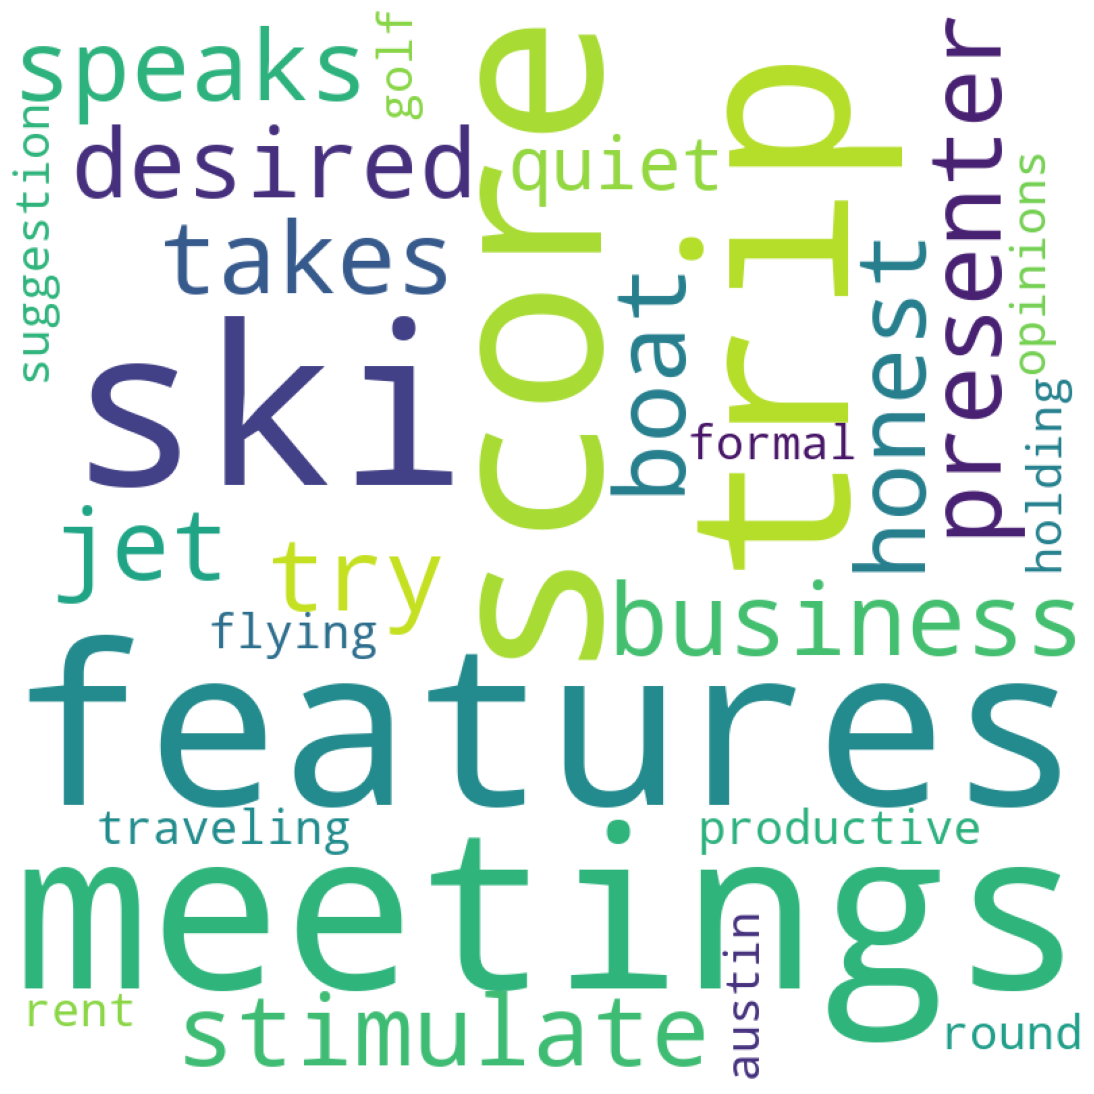

In [89]:
#creating WordCloud object

top_words = str(top_df)
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = 'english', 
                min_font_size = 10).generate(top_words)

# plot the WordCloud image                        
plt.figure(figsize = (15,15), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

Now that we have everything all settled, we can use K-Means Clustering to separate our data. The goal here is hopefully to sort everything into sections, people and important words. We'll use these later on as labels in our supervised learning task.

K-means is a clustering algorithm that aims to partition the data into k clusters. These clusters are organized by separating each observation and linking it to the cluster with the nearest mean.

We'll actually use the mini-batch Kmeans algorithm from sklearn. This way we won't read the whole dataset into memory at the same time. We'll use a batch size of 500 and run 100 iterations.

In [90]:
#initializing with 2 clusters and a batch size
clusters = 2
batch = 500

#timing our model
start = datetime.now()
#starting with 100 iterations using minibatch 
kmeans = MiniBatchKMeans(n_clusters = clusters, max_iter=100, batch_size=batch)
labels = kmeans.fit_predict(X)

end= datetime.now()
print(f"Elapsed time",(end-start))

Elapsed time 0:00:24.229771


<function matplotlib.pyplot.show(close=None, block=None)>

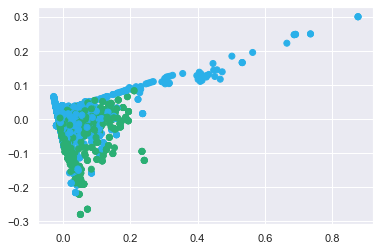

In [91]:
#reusing our previous variables but adding the labels for color (min number of colors is n_clusters)
label = labels[:10000]

label_colors = ["#2AB0E9","#2BAF74","#D7665E","#CCCCCC"]

colors = [label_colors[i] for i in label]

#crating coordinates for a plot using PCA
coords = PCA(n_components =2).fit_transform(X_dense)
x= coords[:,0]
y=coords[:,1]


#creating the plot 
plt.scatter(x,y, c=colors)
plt.show

In [94]:
#looking at the top 25 words/scores
row = np.squeeze(X[1].toarray())
topn_ids = np.argsort(row)[::1][:n]
top_feats = [(feats[i], row[i]) for i in topn_ids]
top_df2 = pd.DataFrame(top_feats, columns= ["features","score"])
top_df2.head(25)

features  score
0                00    0.0
1           modesty    0.0
2      modestoplant    0.0
3        modestoirr    0.0
4           modesto    0.0
5          modestly    0.0
6           modeste    0.0
7            modest    0.0
8            modesl    0.0
9          modesett    0.0
10            modes    0.0
11      modernworks    0.0
12          moderns    0.0
13  modernmediaohio    0.0
14        modernmed    0.0
15      modernizing    0.0
16       modernized    0.0
17        modernize    0.0
18   modernizations    0.0
19    modernization    0.0
20      modfication    0.0
21      modernizati    0.0
22          modfied    0.0
23          modicum    0.0
24   modified091901    0.0

In [95]:
#adding the cluster ids and looking at the whole dataset
ids = X[clusters].toarray()
ids[ids<0.1]=0
avg_score = np.mean(ids, axis=0)


top_ids = np.argsort(-avg_score)[::1][:n]
all_feats = [(feats[i], avg_score[i]) for i in top_ids]

In [96]:
all_feats

[('successful', 0.6499103431443086),
 ('test', 0.6241990263387842),
 ('way', 0.4335805823509175),
 ('modificatio', 0.0),
 ('modificati', 0.0),
 ('modificastion', 0.0),
 ('modificaitons', 0.0),
 ('modificacoes', 0.0),
 ('modificaciones', 0.0),
 ('modifica', 0.0),
 ('modifiactions', 0.0),
 ('modifi', 0.0),
 ('modied', 0.0),
 ('modicum', 0.0),
 ('modi', 0.0),
 ('modfied', 0.0),
 ('modfication', 0.0),
 ('modesty', 0.0),
 ('modestoplant', 0.0),
 ('modestoirr', 0.0),
 ('modesto', 0.0),
 ('modif', 0.0),
 ('modification', 0.0),
 ('modification_rtp_final', 0.0),
 ('modestly', 0.0)]

In [97]:
top_df_all = pd.DataFrame(all_feats, columns= ["features","score"])
top_df_all.head(25)

features     score
0               successful  0.649910
1                     test  0.624199
2                      way  0.433581
3              modificatio  0.000000
4               modificati  0.000000
5            modificastion  0.000000
6            modificaitons  0.000000
7             modificacoes  0.000000
8           modificaciones  0.000000
9                 modifica  0.000000
10           modifiactions  0.000000
11                  modifi  0.000000
12                  modied  0.000000
13                 modicum  0.000000
14                    modi  0.000000
15                 modfied  0.000000
16             modfication  0.000000
17                 modesty  0.000000
18            modestoplant  0.000000
19              modestoirr  0.000000
20                 modesto  0.000000
21                   modif  0.000000
22            modification  0.000000
23  modification_rtp_final  0.000000
24                modestly  0.000000

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X,labels, test_size=.2, random_state=42)

Counter({0: 9900, 1: 100})


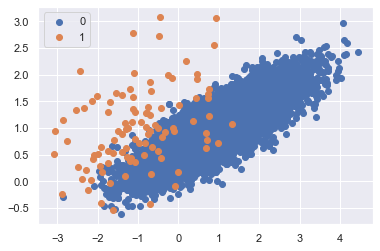

In [117]:
# Generate and plot a synthetic imbalanced classification dataset
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
# summarize class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y == label)[0]
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

In [222]:
#Number of neighbors
n = 3

#creating our knn object
knn = KNeighborsClassifier(n_neighbors=n)

In [223]:
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [224]:
#predicting using test set
pred = knn.predict(X_test)

In [225]:
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print(accuracy_score(y_test,pred))

[[85815  1154]
 [ 1473 10669]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     86969
           1       0.90      0.88      0.89     12142

    accuracy                           0.97     99111
   macro avg       0.94      0.93      0.94     99111
weighted avg       0.97      0.97      0.97     99111

0.9734943649039965


In [226]:
#creating a dataframe to plot the confusion matrix
df_cm = pd.DataFrame(confusion_matrix(y_test, pred),range(2),range(2))
#creating labels for heatmap
labels = confusion_matrix(y_test, pred)

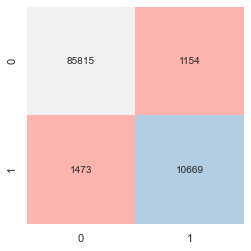

In [227]:
sns.heatmap(df_cm, annot=labels, fmt='.5g',square= True, cmap='Pastel1',cbar=False)
plt.show()

# 5. Conclusion and Recommendations

The goal of this project is to build a classification model to predict if corruption in emails using text mining with the stakeholders being auditors, regulators and company's board of directors who have oversight over company management.

For the purpose of this project, we have used both the email metadata and the emails themselves to identify Enron employees requiring further investigation. The process used a two step analysis where the output of an unsupervised algorithm is used as the input for a supervised learning algorithm to train a model to flag someone as being at risk of committing fraud using their email traffic. 

The model has an F1 score of 97% and would therefore be considered successful as an efficient model to review emails and identify people who may be at risk of committing fraud so that a more in-depth investigation can be performed. 

### Recommendations to further improve the model include:
    
- Getting access to computing resources to run the supervised learning algorithm on the full dataset
- Deeper review of language used in emails to determine if that could be a red flag for fraud